In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
from types import SimpleNamespace

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

The code will run on GPU.


In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform=None, size=128, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        self.train = train
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        self.convert_tensor = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize((size, size))])
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.convert_tensor(Image.open(image_path))
        
        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and idx%5 == 0:
            # Choose another image/label randomly
            mixup_idx = np.random.randint(0, len(self.image_paths)-1)
            mixup_image_path = self.image_paths[mixup_idx]
            mixup_image = self.convert_tensor(Image.open(mixup_image_path))
            c = os.path.split(os.path.split(mixup_image_path)[0])[1]
            mixup_label = self.name_to_label[c]

            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            X = lam * X + (1 - lam) * mixup_image
            y = lam * y + (1 - lam) * mixup_label
            
        if self.transform:
            X = self.transform(X)
            
        return X, y

In [8]:
train_transform = transforms.Compose([transforms.ColorJitter(),
                                      transforms.RandomPerspective(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30)
                                     ])
batch_size = 64

In [9]:
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [5]:
size = 128
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clip(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

train_transform = transforms.Compose([transforms.ColorJitter(),
                                      transforms.RandomApply([AddGaussianNoise(0., 0.2)], 0.5),
                                      transforms.RandomPerspective(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30)
                                     ])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

ValueError: num_samples should be a positive integer value, but got num_samples=0

TypeError: list indices must be integers or slices, not float

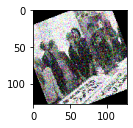

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(10,10))

for i in range(1):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

/tmp/ipykernel_233726/3657376917.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels== np.float(0.1645)


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

(-0.5, 127.5, 127.5, -0.5)

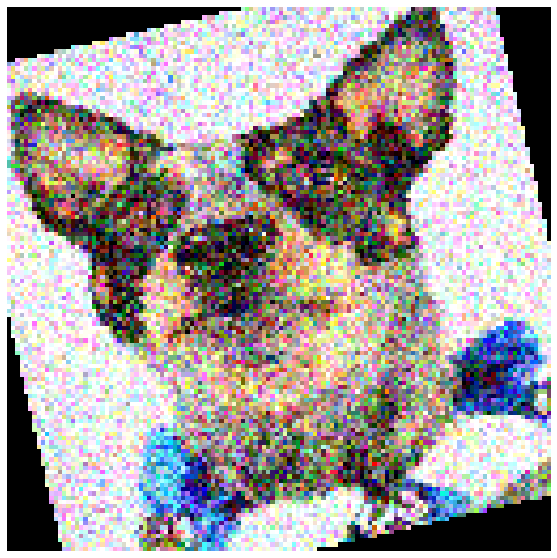

In [29]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(10,10))

plt.imshow(np.swapaxes(np.swapaxes(images[5].numpy(), 0, 2), 0, 1))
#plt.title(['hotdog', 'not hotdog'][labels[i].item()])
plt.axis('off')

In [23]:
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [24]:
class Inception(nn.Module):


    def __init__(self, num_classes=1, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 128x128 => 64x64
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 64x64 => 32x32
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, self.hparams.num_classes),
            nn.Sigmoid()
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [25]:
class Inception_small(nn.Module):


    def __init__(self, num_classes=1, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 128x128 => 64x64
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 64x64 => 32x32
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn)
        )
        
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, self.hparams.num_classes),
            nn.Sigmoid()
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [26]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

In [17]:
# Train 
"""
inception_model = Inception()
num_epochs = 100
learning_rate = 0.0001
criterion = torch.nn.BCELoss()
inception_model.to(device)
optimizer = torch.optim.Adam(inception_model.parameters(), lr=learning_rate, weight_decay=0.01)

inception_model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = inception_model(images)
        loss = criterion(outputs.view(-1).float(), labels.float())
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch}, loss: {loss.item()}')

# Validate the model

inception_model.eval()
corr_pred = 0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = inception_model(images)
    out_labels = torch.round(outputs).view(-1)
    corr_pred += (out_labels == labels).sum().item()
    
print(f'Accuracy is {corr_pred / len(testset)}')
"""


Epoch: 0, loss: 0.6736720204353333
Epoch: 1, loss: 0.6742327809333801
Epoch: 2, loss: 0.5878622531890869
Epoch: 3, loss: 0.5964705944061279
Epoch: 4, loss: 0.5585949420928955
Epoch: 5, loss: 0.5600783228874207
Epoch: 6, loss: 0.5748469233512878
Epoch: 7, loss: 0.6343038082122803
Epoch: 8, loss: 0.5282735824584961
Epoch: 9, loss: 0.6208961606025696
Epoch: 10, loss: 0.5828993916511536
Epoch: 11, loss: 0.5502327084541321
Epoch: 12, loss: 0.47309350967407227
Epoch: 13, loss: 0.3991871476173401
Epoch: 14, loss: 0.6109245419502258
Epoch: 15, loss: 0.49658137559890747
Epoch: 16, loss: 0.4805142283439636
Epoch: 17, loss: 0.4866805672645569
Epoch: 18, loss: 0.43242156505584717
Epoch: 19, loss: 0.4437418282032013
Epoch: 20, loss: 0.3291555643081665
Epoch: 21, loss: 0.41527700424194336
Epoch: 22, loss: 0.5333941578865051
Epoch: 23, loss: 0.33637455105781555
Epoch: 24, loss: 0.5093964338302612
Epoch: 25, loss: 0.43041303753852844
Epoch: 26, loss: 0.34382519125938416
Epoch: 27, loss: 0.392221271991

In [11]:
# Train model
inception_model_s = Inception_small()
num_epochs = 500
learning_rate = 0.001
criterion = torch.nn.BCELoss()
inception_model_s.to(device)
optimizer = torch.optim.Adam(inception_model_s.parameters(), lr=learning_rate, weight_decay = 0.01)

inception_model_s.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = inception_model_s(images)
        loss = criterion(outputs.view(-1).float(), labels.float())
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch}, loss: {loss.item()}')
    
torch.save(res_inception_model, "inception_small_model.pth")

# Validate the model
inception_model_s.eval()
corr_pred = 0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = inception_model_s(images)
    out_labels = torch.round(outputs).view(-1)
    corr_pred += (out_labels == labels).sum().item()
    
print(f'Accuracy is {corr_pred / len(testset)}')



Epoch: 0, loss: 0.6664221882820129
Epoch: 1, loss: 0.6300463676452637
Epoch: 2, loss: 0.5854748487472534
Epoch: 3, loss: 0.6024024486541748
Epoch: 4, loss: 0.5733864307403564
Epoch: 5, loss: 0.5435221791267395
Epoch: 6, loss: 0.518570601940155
Epoch: 7, loss: 0.5348610281944275
Epoch: 8, loss: 0.44078660011291504
Epoch: 9, loss: 0.5206064581871033
Epoch: 10, loss: 0.4398280084133148
Epoch: 11, loss: 0.5914318561553955
Epoch: 12, loss: 0.49439671635627747
Epoch: 13, loss: 0.5721287131309509
Epoch: 14, loss: 0.4988526999950409
Epoch: 15, loss: 0.5238689184188843
Epoch: 16, loss: 0.5149417519569397
Epoch: 17, loss: 0.4720900356769562
Epoch: 18, loss: 0.4695889949798584
Epoch: 19, loss: 0.4527589976787567
Epoch: 20, loss: 0.5118915438652039
Epoch: 21, loss: 0.40843015909194946
Epoch: 22, loss: 0.40264615416526794
Epoch: 23, loss: 0.4343065917491913
Epoch: 24, loss: 0.380700945854187
Epoch: 25, loss: 0.3726721405982971
Epoch: 26, loss: 0.45945724844932556
Epoch: 27, loss: 0.3765231668949127